In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import os

In [2]:
# Read subway and bus ridership data at entrances and exits
DT_ridership_in = np.load(r'../DT_ridership_in.npy')
DT_ridership_ou = np.load(r"../DT_ridership_ou.npy")

GJ_ridership_in = np.load(r'../GJ_DT_flowin.npy')
GJ_ridership_ou = np.load(r"../GJ_DT_flowou.npy")

In [3]:
DT_ridership_in.shape

(329, 31, 96)

In [4]:
# Delete subway and bus inbound and outbound ridership data on May 11
DT_ridership_in = np.delete(DT_ridership_in, 10, axis=1)
GJ_ridership_in = np.delete(GJ_ridership_in, 10, axis=1)
DT_ridership_ou = np.delete(DT_ridership_ou, 10, axis=1)
GJ_ridership_ou = np.delete(GJ_ridership_ou, 10, axis=1)

# Delete the time period from 00:00 to 05:00 each day (indices 0-19)
DT_ridership_in = np.delete(DT_ridership_in, np.arange(20), axis=2)
GJ_ridership_in = np.delete(GJ_ridership_in, np.arange(20), axis=2)
DT_ridership_ou = np.delete(DT_ridership_ou, np.arange(20), axis=2)
GJ_ridership_ou = np.delete(GJ_ridership_ou, np.arange(20), axis=2)

In [5]:
print(DT_ridership_in.shape,  DT_ridership_ou.shape, GJ_ridership_in.shape,  GJ_ridership_ou.shape)

(329, 30, 76) (329, 30, 76) (329, 30, 76) (329, 30, 76)


In [6]:
# Training set (1st–23rd, i.e., the first 23 days, with the 15th removed, total 22 days)
train_data = DT_ridership_in[:, :22, :]
train_label = DT_ridership_ou[:, :22, :]
train_GJ_in = GJ_ridership_in[:, :22, :]
train_GJ_ou = GJ_ridership_ou[:, :22, :]
# Test set (24th–31st, i.e., from the 24th to the 31st day)
test_data = DT_ridership_in[:, 22:, :]
test_label = DT_ridership_ou[:, 22:, :]
test_GJ_in = GJ_ridership_in[:, 22:, :]
test_GJ_ou = GJ_ridership_ou[:, 22:, :]


In [7]:
# Print shape check
print("Training set shape:", train_data.shape)  
print("Test set shape:", test_data.shape)   
print("train_label shape:", train_label.shape)  
print("test_label shape:", test_label.shape)  

Training set shape: (329, 22, 76)
Test set shape: (329, 8, 76)
train_label shape: (329, 22, 76)
test_label shape: (329, 8, 76)


In [8]:
train_data_in = train_data.reshape(329, 22 * 76)
train_data_out = train_label.reshape(329, 22 * 76)
test_data_in = test_data.reshape(329, 8 * 76)
test_data_out = test_label.reshape(329, 8 * 76)

train_GJ_in = train_GJ_in.reshape(329, 22 * 76)
train_GJ_ou = train_GJ_ou.reshape(329, 22 * 76)
test_GJ_in = test_GJ_in.reshape(329, 8 * 76)
test_GJ_ou = test_GJ_ou.reshape(329, 8 * 76)

In [9]:
train_data_in = train_data_in.transpose(1, 0)
train_data_out = train_data_out.transpose(1, 0)
test_data_in = test_data_in.transpose(1, 0)
test_data_out = test_data_out.transpose(1, 0)

train_GJ_in = train_GJ_in.transpose(1, 0)
train_GJ_ou = train_GJ_ou.transpose(1, 0)
test_GJ_in = test_GJ_in.transpose(1, 0)
test_GJ_ou = test_GJ_ou.transpose(1, 0)

In [10]:
train_data_in.shape

(1672, 329)

In [11]:
test_data_out.shape

(608, 329)

In [12]:
x_train_in= []
x_train_out= []
y_train_in = []
y_train_out = []
# Subway data time step processing
for kk in range(12,1668):
    x_train_in = x_train_in + [np.array(train_data_in[kk-12:kk])]
    y_train_in = y_train_in + [np.array(train_data_in[kk:kk+4])]
    x_train_out = x_train_out + [np.array(train_data_out[kk-12:kk])]
    y_train_out = y_train_out + [np.array(train_data_out[kk:kk+4])]

x_train_in = np.array(x_train_in)   
x_train_out = np.array(x_train_out) 
y_train_in = np.array(y_train_in)   
y_train_out = np.array(y_train_out) 
x_train = np.concatenate([x_train_in, x_train_out], axis=0)
y_train = np.concatenate([y_train_in, y_train_out], axis=0)
x_train = np.array(x_train).astype(float)
y_train = np.array(y_train).astype(float)
print(x_train.shape, y_train.shape)

(3312, 12, 329) (3312, 4, 329)


In [13]:
x_GJ_in= []
x_GJ_out= []
y_GJ_in = []
y_GJ_out = []
# Bus data time step processing
for kk in range(12,1668):
    x_GJ_in = x_GJ_in + [np.array(train_GJ_in[kk-12:kk])]
    y_GJ_in = y_GJ_in + [np.array(train_GJ_in[kk:kk+4])]
    x_GJ_out = x_GJ_out + [np.array(train_GJ_ou[kk-12:kk])]
    y_GJ_out = y_GJ_out + [np.array(train_GJ_ou[kk:kk+4])]
x_GJ_in = np.array(x_GJ_in)   
x_GJ_out = np.array(x_GJ_out) 
y_GJ_in = np.array(y_GJ_in)   
y_GJ_out = np.array(y_GJ_out) 
x_GJ = np.concatenate([x_GJ_in, x_GJ_out], axis=0)
y_GJ = np.concatenate([y_GJ_in, y_GJ_out], axis=0)
x_GJ = np.array(x_GJ).astype(float)
y_GJ = np.array(y_GJ).astype(float)
print(x_GJ.shape, y_GJ.shape)

(3312, 12, 329) (3312, 4, 329)


In [14]:
# Concatenate along the last dimension to obtain (num_samples, 12, 2), i.e., subway-bus modal fusion input
x_train = np.stack([x_train, x_GJ], axis=-1)
y_train = np.concatenate([y_train], axis=-1)
x_train = np.array(x_train).astype(float)
y_train = np.array(y_train).astype(float)
print(x_train.shape, y_train.shape)

(3312, 12, 329, 2) (3312, 4, 329)


In [15]:
from sklearn.model_selection import train_test_split

x_tra, x_val, y_tra, y_val  = train_test_split(
    x_train, y_train, test_size=1/8, shuffle=True, random_state=42  
)

print(f"x_train shape: {x_tra.shape}, x_val shape: {x_val.shape}")
print(f"y_train shape: {y_tra.shape}, y_val shape: {y_val.shape}")

x_train shape: (2898, 12, 329, 2), x_val shape: (414, 12, 329, 2)
y_train shape: (2898, 4, 329), y_val shape: (414, 4, 329)


In [16]:
import tensorflow as tf
import numpy as np

# Define moving average module
class MovingAvg(tf.keras.layers.Layer):
    def __init__(self, kernel_size, stride):
        super(MovingAvg, self).__init__()
        self.kernel_size = kernel_size
        self.avg_pool = tf.keras.layers.AveragePooling1D(pool_size=kernel_size, strides=stride, padding="valid")
 
    def call(self, x):
        front = tf.repeat(x[:, 0:1 ,:], repeats=(self.kernel_size - 1) // 2, axis=1)
        end = tf.repeat(x[:, -1:, :], repeats=(self.kernel_size - 1) // 2, axis=1)
        
        x = tf.concat([front, x, end], axis=1)
        x = self.avg_pool(x)
        return x

# Define time series decomposition module
class SeriesDecomp(tf.keras.layers.Layer):
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)
 
    def call(self, x):
        moving_mean = self.moving_avg(x)
        res = x[:, :tf.shape(moving_mean)[1]] - moving_mean
        return res, moving_mean

In [17]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Dense(ff_dim, activation="elu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1], activation="elu")(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [18]:
# Define dynamic adjacency matrix generator
class DynamicAdjGenerator(layers.Layer):
    def __init__(self, static_adj, num_nodes, window_size=6):
        super().__init__()
        self.static_adj = tf.constant(static_adj, dtype=tf.float32) 
        self.num_nodes = num_nodes
        self.window = window_size
        
        # Temporal causal relationship learning network
        self.temporal_net = tf.keras.Sequential([
            layers.Conv1D(8, 3, activation='elu',padding="same"),
            layers.Conv1D(1, 3, activation='elu',padding="same"),
            layers.Flatten(),
            layers.Dense(5, activation='elu'),  
            layers.Dense(num_nodes*num_nodes, activation='sigmoid') 
        ])
    
    def call(self, x):
        """Input x: [batch, T, N, C]  Output dynamic adjacency matrix: [batch, N, N]"""
        window_data = x[:, -self.window:]  
        temporal_weights = self.temporal_net(tf.transpose(window_data, [0,2,1,3]))  
        temporal_weights = tf.reshape(temporal_weights, [-1, self.num_nodes, self.num_nodes])
        dyn_adj = self.static_adj * tf.nn.sigmoid(temporal_weights)  
        return dyn_adj
    
    
# Define GCN layer (supports dynamic adjacency matrix input)
class DynamicGCNLayer(layers.Layer):
    def __init__(self, output_dim, activation=None):
        super().__init__()
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.output_dim),
                                 initializer='glorot_uniform',
                                 name='gcn_weights')
        super().build(input_shape)
    
    def call(self, inputs, adjacency):
        """Inputs:
           inputs: [batch*time, N, F]
           adjacency: [batch, N, N] dynamic adjacency matrix
        """
        adj = tf.repeat(adjacency, tf.shape(inputs)[0]//tf.shape(adjacency)[0], axis=0)  # [B*T,N,N]
        h = tf.matmul(inputs, self.w)  
        output = tf.einsum('bij,bjk->bik', adj, h)  
        return self.activation(output) if self.activation else output

In [19]:
# ==== Proper initialization in the model ====
# Static adjacency matrix preprocessing
adj = pd.read_csv("../DT_ADJ.csv", header=None)

def normalize_adj(adj):
    adj += np.eye(adj.shape[0])  # Add self-connections
    degree = np.sum(adj, axis=1)
    degree_mat = np.diag(np.power(degree, -0.5))
    return degree_mat @ adj @ degree_mat

norm_adj = tf.constant(normalize_adj(adj), dtype=tf.float32)

In [20]:
def gnn_process_seasonal_trend(inputs, num_nodes, pred_len, adj, individual):
    seasonal_init, trend_init = SeriesDecomp(kernel_size=12)(inputs)  
    seasonal_init = tf.transpose(seasonal_init, perm=[0, 2, 1])  
    trend_init = tf.transpose(trend_init, perm=[0, 2, 1])        
        
    if individual:         # DLinear-I: each variable has its own independent linear layer
        seasonal_output = []
        trend_output = []
 
        for i in range(num_nodes):
            seasonal_output_i = layers.Dense(pred_len)(seasonal_init[:, i])
            trend_output_i = layers.Dense(pred_len)(trend_init[:, i])
            seasonal_output.append(seasonal_output_i)
            trend_output.append(trend_output_i)

        seasonal_output = tf.stack(seasonal_output, axis=-1)  
        adj_gen = DynamicAdjGenerator(norm_adj, num_nodes)
        dyn_adj1 = adj_gen(tf.reshape(seasonal_output, [-1, pred_len, 329, 1]))  
        
        seasonal_output = tf.reshape(seasonal_output, [-1, 329, 1])  
        seasonal_output = DynamicGCNLayer(12, 'elu')(seasonal_output, dyn_adj1)
        seasonal_output = layers.Dense(1)(seasonal_output)
        seasonal_output = tf.reshape(seasonal_output, [-1, pred_len, 329])  

        trend_output = tf.stack(trend_output, axis=-1)        
        dyn_adj2 = adj_gen(tf.reshape(trend_output, [-1, pred_len, 329, 1]))  
        
        trend_output = tf.reshape(trend_output, [-1, 329, 1]) 
        trend_output = DynamicGCNLayer(12, 'elu')(trend_output, dyn_adj2)
        trend_output = layers.Dense(1)(trend_output)
        trend_output = tf.reshape(trend_output, [-1, pred_len, 329]) 
    else:                      
        seasonal_output = layers.Dense(pred_len)(seasonal_init)
        trend_output = layers.Dense(pred_len)(trend_init)
        
        adj_gen = DynamicAdjGenerator(norm_adj, num_nodes)
        dyn_adj1 = adj_gen(tf.reshape(seasonal_output, [-1, pred_len, 329, 1]))  
        
        seasonal_output = tf.reshape(seasonal_output, [-1, 329, 1])  
        seasonal_output = DynamicGCNLayer(12, 'elu')(seasonal_output, dyn_adj1)
        seasonal_output = layers.Dense(1)(seasonal_output)
        seasonal_output = tf.reshape(seasonal_output, [-1, pred_len, 329])  

        # trend_output  # [Batch, Time, Nodes]  
        dyn_adj2 = adj_gen(tf.reshape(trend_output, [-1, pred_len, 329, 1]))  
        
        trend_output = tf.reshape(trend_output, [-1, 329, 1]) 
        trend_output = DynamicGCNLayer(12, 'elu')(trend_output, dyn_adj2)
        trend_output = layers.Dense(1)(trend_output)
        trend_output = tf.reshape(trend_output, [-1, pred_len, 329]) 
            
    return seasonal_output + trend_output


In [21]:
import keras.backend as K

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [22]:
a_2d = tf.constant([[1,2,3],[-1,-2,-3]])
b_2d = tf.constant([2]*6, shape=[2, 3])
c_2d = tf.multiply(a_2d, b_2d)
c_2d

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 2,  4,  6],
       [-2, -4, -6]])>

In [23]:
class SpatioTemporalAttention(layers.Layer):
    def __init__(self, num_nodes, pred_len, head_size=32, temporal_heads=4, spatial_heads=4):
        super().__init__()
        self.num_nodes = num_nodes
        self.pred_len = pred_len
        
        # Temporal attention mechanism
        self.temporal_attn = layers.MultiHeadAttention(num_heads=temporal_heads, key_dim=head_size)
        # Spatial attention mechanism
        self.spatial_attn = layers.MultiHeadAttention(num_heads=spatial_heads, key_dim=head_size)
        
        # Spatio-temporal fusion gating
        self.gate_net = tf.keras.Sequential([
            layers.Dense(64, activation='swish'),
            layers.Dense(2 * num_nodes, activation='sigmoid')])
        
        # Feed-forward network components (pre-initialized)
        self.s_dense1 = layers.Dense(64, activation='swish')
        self.s_dense2 = layers.Dense(pred_len)
        self.t_dense1 = layers.Dense(64, activation='swish')
        self.t_dense2 = layers.Dense(num_nodes)
        
    
    def build(self, input_shape):
        self.temp_pe = self.add_weight(
            shape=(1, self.pred_len, 1),
            initializer='glorot_uniform',
            name='temp_pe')
        self.spat_pe = self.add_weight(
            shape=(1, 1, self.num_nodes),
            initializer='glorot_uniform',
            name='spat_pe')
        super().build(input_shape)
    
    def call(self, inputs):
        # Add spatio-temporal positional encoding
        x = inputs + self.temp_pe + self.spat_pe
        
        # Attention on temporal dimension
        t_attn = self.temporal_attn(x, x)
        
        # Attention on spatial dimension
        s_input = tf.transpose(x, [0, 2, 1])  
        s_attn = self.spatial_attn(s_input, s_input)
        s_attn = tf.transpose(s_attn, [0, 2, 1])  
        
        # Dynamic gating fusion
        gate = self.gate_net(inputs)
        gate_t, gate_s = tf.split(gate, 2, axis=-1)
        fused = gate_t * t_attn + gate_s * s_attn
        
        # Residual connection
        output = inputs + fused
        return output + self.feed_forward(output)
    
    def feed_forward(self, x):
        # Spatial feature processing
        s_feat = tf.transpose(x, [0, 2, 1])  
        s_feat = self.s_dense1(s_feat)
        s_feat = self.s_dense2(s_feat)
        s_feat = tf.transpose(s_feat, [0, 2, 1])  
        
        # Temporal feature processing
        t_feat = self.t_dense1(x)
        t_feat = self.t_dense2(t_feat)
        
        return s_feat + t_feat


In [24]:
num_nodes = 329
pred_len = 4
# Create model instance
inputs = tf.keras.Input(shape=(12, 329, 2))  

dt_in, gj_in  = tf.split(inputs, num_or_size_splits=2, axis=-1)
        
dt_in = tf.keras.layers.Reshape((12, 329))(dt_in) 
dt_in = gnn_process_seasonal_trend(dt_in, num_nodes, pred_len, adj, individual=True)  
gj_in = tf.keras.layers.Reshape((12, 329))(gj_in) 
gj_in = gnn_process_seasonal_trend(gj_in, num_nodes, pred_len, adj, individual=True)  

atten = layers.MultiHeadAttention(key_dim=4, num_heads=2, dropout=0.1)(dt_in, gj_in)  
fusi = layers.Dense(32, activation='elu')(dt_in + gj_in)
fusi = layers.Dense(329, activation='sigmoid')(fusi)
dtgj = dt_in + tf.multiply(fusi, atten)   

dtgj = SpatioTemporalAttention(num_nodes=329, pred_len=pred_len, head_size=32, temporal_heads=4, spatial_heads=4)(dtgj)

# Build model
model = tf.keras.Model(inputs=inputs, outputs=dtgj)
model.compile(optimizer="Adam", loss=rmse, metrics=['mae'])


In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 329, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.split (TFOpLambda)          [(None, 12, 329, 1)  0           ['input_1[0][0]']                
                                , (None, 12, 329, 1                                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 12, 329)      0           ['tf.split[0][0]']           

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



                                                                 ][0]']                           
                                                                                                  
 dense_1282 (Dense)             (None, 4)            48          ['tf.__operators__.getitem_1278[0
                                                                 ][0]']                           
                                                                                                  
 dense_1284 (Dense)             (None, 4)            48          ['tf.__operators__.getitem_1280[0
                                                                 ][0]']                           
                                                                                                  
 dense_1286 (Dense)             (None, 4)            48          ['tf.__operators__.getitem_1282[0
                                                                 ][0]']                           
          

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_644 (  (None, 11)          0           ['tf.compat.v1.transpose[0][0]'] 
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_646 (  (None, 11)          0           ['tf.compat.v1.transpose[0][0]'] 
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_648 (  (None, 11)          0           ['tf.compat.v1.transpose[0][0]'] 
 SlicingOpLambda)                                                                                 
          

 tf.__operators__.getitem_41 (S  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 licingOpLambda)                                                 ]                                
                                                                                                  
 tf.__operators__.getitem_43 (S  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 licingOpLambda)                                                 ]                                
                                                                                                  
 tf.__operators__.getitem_45 (S  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 licingOpLambda)                                                 ]                                
                                                                                                  
 tf.__operators__.getitem_47 (S  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 licingOpL

                                                                                                  
 tf.__operators__.getitem_97 (S  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 licingOpLambda)                                                 ]                                
                                                                                                  
 tf.__operators__.getitem_99 (S  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 licingOpLambda)                                                 ]                                
                                                                                                  
 tf.__operators__.getitem_101 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__oper

 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_153 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_155 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_157 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
          

 tf.__operators__.getitem_207 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_209 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_211 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_213 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOp

                                                                                                  
 tf.__operators__.getitem_263 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_265 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_267 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__oper

 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_319 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_321 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_323 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
          

 tf.__operators__.getitem_373 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_375 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_377 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_379 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOp

                                                                                                  
 tf.__operators__.getitem_429 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_431 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_433 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__oper

 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_485 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_487 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_489 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
          

 tf.__operators__.getitem_539 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_541 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_543 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_545 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOp

                                                                                                  
 tf.__operators__.getitem_595 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_597 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_599 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__oper

 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_651 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_653 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_655 (  (None, 11)          0           ['tf.compat.v1.transpose_1[0][0]'
 SlicingOpLambda)                                                ]                                
          

 tf.__operators__.getitem_704 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_706 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_708 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_710 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOp

                                                                                                  
 tf.__operators__.getitem_760 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_762 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_764 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__oper

 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_816 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_818 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_820 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
          

 tf.__operators__.getitem_870 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_872 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_874 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_876 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOp

                                                                                                  
 tf.__operators__.getitem_926 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_928 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_930 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__oper

 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_982 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_984 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_986 (  (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 SlicingOpLambda)                                                ]                                
          

 tf.__operators__.getitem_1036   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1038   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1040   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1042   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingO

                                                                                                  
 tf.__operators__.getitem_1092   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1094   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1096   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__oper

 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1148   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1150   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1152   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
          

 tf.__operators__.getitem_1202   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1204   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1206   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1208   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingO

                                                                                                  
 tf.__operators__.getitem_1258   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1260   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1262   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__oper

 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_1314   (None, 11)          0           ['tf.compat.v1.transpose_2[0][0]'
 (SlicingOpLambda)                                               ]                                
                                                                                                  
 tf.__operators__.getitem_659 (  (None, 11)          0           ['tf.compat.v1.transpose_3[0][0]'
 SlicingOpLambda)                                                ]                                
                                                                                                  
 tf.__operators__.getitem_661 (  (None, 11)          0           ['tf.compat.v1.transpose_3[0][0]'
 SlicingOpLambda)                                                ]                                
          

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
# Test input and output
test_in = tf.random.normal((32, 12, 329, 2)) 
prediction = model.predict(test_in)
print("Prediction shape:", prediction.shape)  

1/1 [==============================] - 475s 475s/step
Prediction shape: (32, 4, 329)


In [27]:
from keras.callbacks import EarlyStopping
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',  
                               patience=20,         
                               restore_best_weights=True)  

In [28]:
hist = model.fit(x_tra, y_tra, validation_data=(x_val, y_val), epochs= 200, batch_size=12, \
                 callbacks=[early_stopping],shuffle=True)

Epoch 1/200
242/242 [==============================] - 202s 255ms/step - loss: 101.2651 - mae: 56.4734 - val_loss: 62.3702 - val_mae: 36.4382
Epoch 2/200
242/242 [==============================] - 44s 181ms/step - loss: 56.0980 - mae: 32.4618 - val_loss: 51.2242 - val_mae: 29.4622
Epoch 3/200
242/242 [==============================] - 56s 232ms/step - loss: 47.7228 - mae: 27.7124 - val_loss: 44.8246 - val_mae: 25.5875
Epoch 4/200
242/242 [==============================] - 56s 232ms/step - loss: 43.1986 - mae: 25.1446 - val_loss: 44.0678 - val_mae: 25.0241
Epoch 5/200
242/242 [==============================] - 45s 186ms/step - loss: 40.4438 - mae: 23.6165 - val_loss: 46.0182 - val_mae: 27.9642
Epoch 6/200
242/242 [==============================] - 48s 197ms/step - loss: 40.6059 - mae: 23.4925 - val_loss: 42.8224 - val_mae: 23.8917
Epoch 7/200
242/242 [==============================] - 58s 240ms/step - loss: 36.8107 - mae: 21.3808 - val_loss: 36.9448 - val_mae: 21.0074
Epoch 8/200
242/24

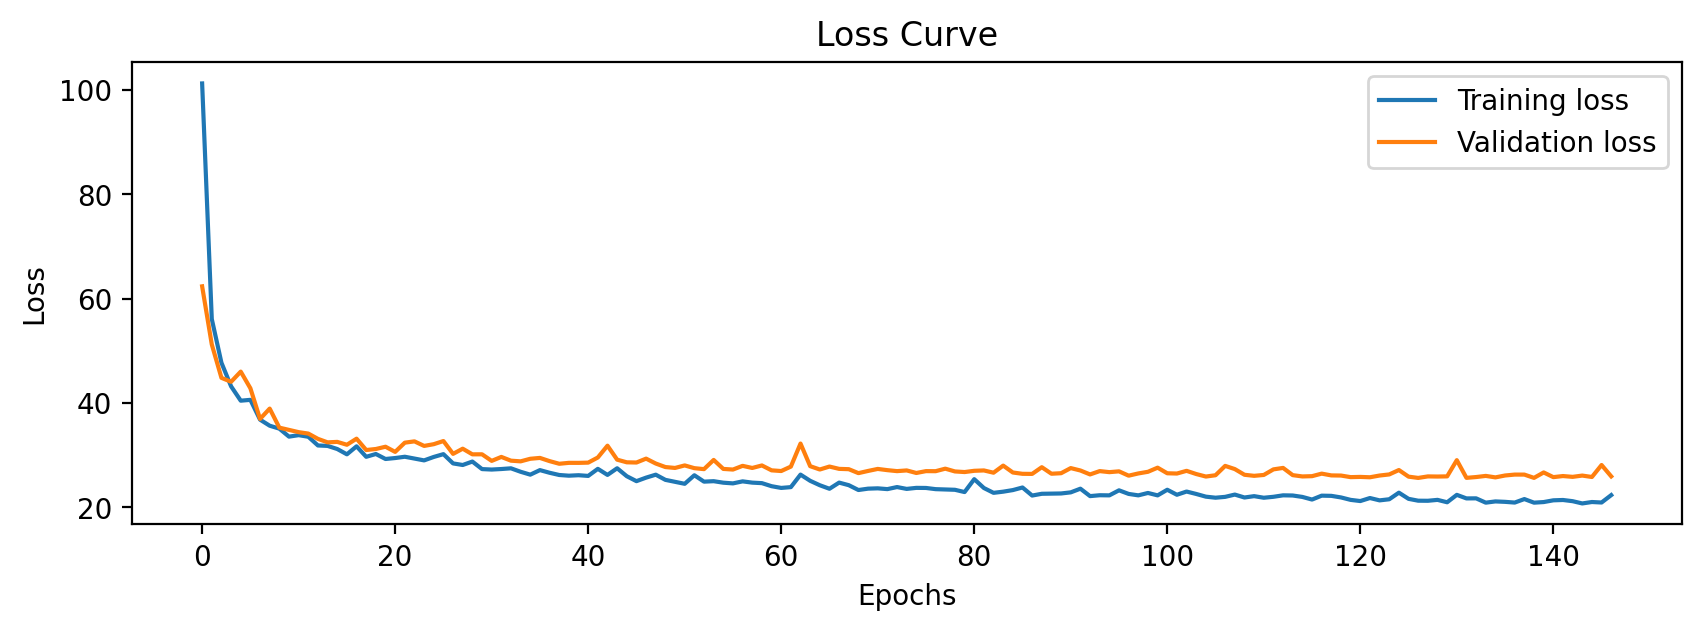

In [29]:
plt.figure(figsize=(10,3),dpi=200)
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 进行测试

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import math

def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

def wmape(y_true, y_pred):
    weights = y_true / np.sum(y_true)
    absolute_errors = np.abs((y_true - y_pred) / (y_true+ (y_true==0)*0.00001))
    return np.sum(weights * absolute_errors) * 100

def fenduan(y_test, y_predict):
    MAE = mean_absolute_error(y_test, y_predict)
    RMSE = math.sqrt(mean_squared_error(y_test, y_predict))
    WMAPE = wmape(y_test, y_predict)

    print("mean_absolute_error:", MAE)
    print("mean_squared_error:", mean_squared_error(y_test, y_predict))
    print("rmse:", RMSE)
    print("WMAPE:", WMAPE)

    print("MAE:", round(MAE, 2), "RMSE:", round(RMSE, 4), "WMAPE:", round(WMAPE, 2))

In [31]:
x_test_in= []
x_test_out= []
y_test_in = []
y_test_out = []
for kk in range(12,604):
    x_test_in = x_test_in + [np.array(test_data_in[kk-12:kk])]
    y_test_in = y_test_in + [np.array(test_data_in[kk:kk+4])]
    x_test_out = x_test_out + [np.array(test_data_out[kk-12:kk])]
    y_test_out = y_test_out + [np.array(test_data_out[kk:kk+4])]
    
x_test_in = np.array(x_test_in)   
x_test_out = np.array(x_test_out) 
y_test_in = np.array(y_test_in)   
y_test_out = np.array(y_test_out) 

x_test = np.concatenate([x_test_in, x_test_out], axis=0)
y_test = np.concatenate([y_test_in, y_test_out], axis=0)
x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)
print(x_test.shape, y_test.shape)

(1184, 12, 329) (1184, 4, 329)


In [32]:
x_GJ_in= []
x_GJ_out= []
y_GJ_in = []
y_GJ_out = []
for kk in range(12,604):
    x_GJ_in = x_GJ_in + [np.array(test_GJ_in[kk-12:kk])]
    y_GJ_in = y_GJ_in + [np.array(test_GJ_in[kk:kk+4])]
    x_GJ_out = x_GJ_out + [np.array(test_GJ_ou[kk-12:kk])]
    y_GJ_out = y_GJ_out + [np.array(test_GJ_ou[kk:kk+4])]

x_GJ_in = np.array(x_GJ_in)   
x_GJ_out = np.array(x_GJ_out) 
y_GJ_in = np.array(y_GJ_in)   
y_GJ_out = np.array(y_GJ_out)

x_GJ = np.concatenate([x_GJ_in, x_GJ_out], axis=0)
y_GJ = np.concatenate([y_GJ_in, y_GJ_out], axis=0)
x_GJ = np.array(x_GJ).astype(float)
y_GJ = np.array(y_GJ).astype(float)
print(x_GJ.shape, y_GJ.shape)

x_test = np.stack([x_test, x_GJ], axis=-1)
y_test = np.concatenate([y_test], axis=-1)
x_test = np.array(x_test).astype(float)
y_test = np.array(y_test).astype(float)
print(x_test.shape, y_test.shape)

(1184, 12, 329) (1184, 4, 329)
(1184, 12, 329, 2) (1184, 4, 329)


In [33]:
pred = model.predict(x_test)
print(pred.shape)

37/37 [==============================] - 4s 103ms/step
(1184, 4, 329)


In [34]:
fenduan(y_test.reshape([-1]),pred.reshape([-1]))

mean_absolute_error: 14.748266804341325
mean_squared_error: 610.1207470879388
rmse: 24.700622402845212
WMAPE: 10.955646827259168
MAE: 14.75 RMSE: 24.7006 WMAPE: 10.96


In [35]:
model.save_weights('Graph-Dlinear-4hv4.h5')

In [36]:
np.save("pred-Graph-Dlinear-4hv4.npy",pred)